In [99]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import *

set_seaborn_paper_context()

In [100]:
figs_dir = Path("../figures/main")
sup_figs_dir = Path("../figures/supplementary")
sup_tabs_dir = Path("../tables/supplementary")
tabs_dir = Path("../tables/main")
sup_figs_dir = sup_figs_dir / "clustering"

ensure_dirs(figs_dir, sup_figs_dir, tabs_dir, sup_tabs_dir)

edge_eval_metrics = pd.read_csv(sup_tabs_dir / "edge_eval_metrics.csv")
clustering_metrics = pd.read_csv(sup_tabs_dir / "clustering_metrics.csv")
clustering_stability = pd.read_csv(sup_tabs_dir / "clustering_stability.csv")

model_label_map = {
    "LinearDistScore": "Lin–Score",
    "MechProbLinearDist": "Lin–Mech",
    "LogitProbLinearDist_0.1": "Lin–Logit(0.1)",
    "LogitProbLinearDist_1.0": "Lin–Logit(1.0)",
    "PoissonDistScore": "Pois–Score",
    "MechProbPoissonDist": "Pois–Mech",
    "LogitProbPoissonDist_0.1": "Pois–Logit(0.1)",
    "LogitProbPoissonDist_1.0": "Pois–Logit(1.0)",
}

scenario_label_map = {
    "baseline": "Baseline",

     # Surveillance scenarios
    "surveillance_moderate": "Surveillance (moderate)",
    "surveillance_severe": "Surveillance (severe)",

     # High evolutionary signal scenarios
    "high_clock_signal": "High clock signal",
    "high_k_inc": "High incubation shape",
    "high_scale_inc": "High incubation scale",

    # Low evolutionary signal scenarios
    "low_clock_signal": "Low clock signal",
    "low_k_inc": "Low incubation shape",
    "low_scale_inc": "Low incubation scale",

    "relaxed_clock": "Relaxed clock",
    "adversarial": "Adversarial",
}

## Edge-level discrimination of recent transmission across sensitivity scenarios

In [101]:
def parse_method(row_model: str):
    m = row_model
    # Divergence regime
    if "Linear" in m or m == "LinearDistScore":
        divergence = "Deterministic (Lin)"
    elif "Poisson" in m or m == "PoissonDistScore":
        divergence = "Stochastic (Pois)"
    else:
        divergence = "Unknown"

    # Method family + training fraction (if any)
    if m in ["LinearDistScore", "PoissonDistScore"]:
        family = "Genetic-only score"
        train_frac = None
    elif m.startswith("MechProb"):
        family = "Mechanistic probability"
        train_frac = None
    elif m.startswith("LogitProb"):
        family = "Logistic regression"
        # extract 0.1 or 1.0 if present
        mt = re.search(r"_(0\.1|1\.0)$", m)
        train_frac = float(mt.group(1)) if mt else None
    else:
        family = "Other"
        train_frac = None

    return pd.Series({"Family": family, "TrainFrac": train_frac, "Divergence": divergence})

edge_eval_metrics_meta = edge_eval_metrics["Model"].apply(parse_method)
edge_eval_metrics = pd.concat([edge_eval_metrics, edge_eval_metrics_meta], axis=1)

edge_eval_metrics["ModelLabel"] = edge_eval_metrics["Model"].map(model_label_map)
edge_eval_metrics["ScenarioLabel"] = edge_eval_metrics["Scenario"].map(scenario_label_map)

### Figure 1: Relative PR–AUC heatmap (ratio-to-baseline)

Model
LinearDistScore             0.843206
PoissonDistScore            0.152983
MechProbLinearDist          1.000000
MechProbPoissonDist         0.387121
LogitProbLinearDist_0.1     1.000000
LogitProbPoissonDist_0.1    0.406692
LogitProbLinearDist_1.0     1.000000
LogitProbPoissonDist_1.0    0.406692
Name: PR_AUC, dtype: float64


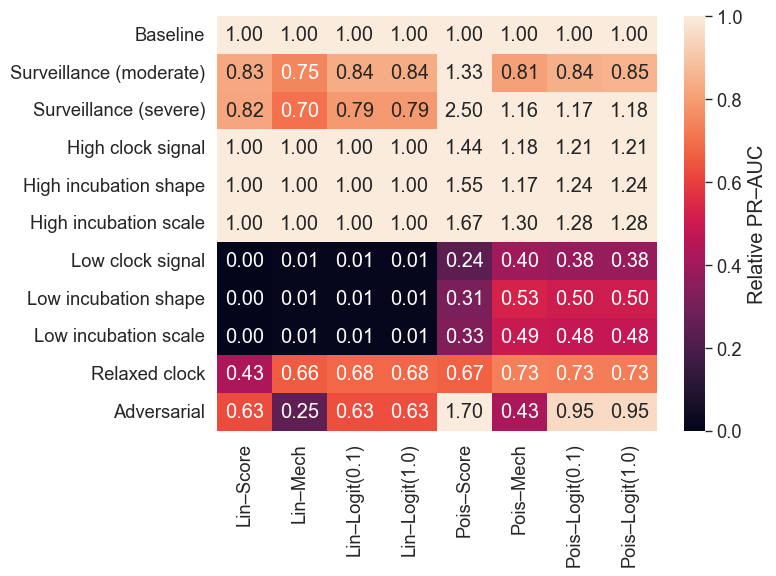

In [109]:
# Baseline PR-AUC per model
baseline = (
    edge_eval_metrics[edge_eval_metrics["Scenario"] == "baseline"]
    .set_index("Model")["PR_AUC"]
)

print(baseline)

# Compute ratio
edge_eval_metrics["PR_AUC_ratio_to_baseline"] = edge_eval_metrics.apply(
    lambda r: r["PR_AUC"] / baseline.get(r["Model"], np.nan),
    axis=1
)

# Pivot for heatmap: rows=scenario, cols=model label
heat = edge_eval_metrics.pivot_table(
    index="ScenarioLabel",
    columns="ModelLabel",
    values="PR_AUC_ratio_to_baseline",
    aggfunc="first"
).sort_index()

# Order columns and rows according to label maps
model_order = list(model_label_map.values())
scenario_order = list(scenario_label_map.values())

heat = heat[[c for c in model_order if c in heat.columns]]
heat = heat.reindex(scenario_order)

fig1 = plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heat,
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    cbar_kws={"label": "Relative PR–AUC"}
)

ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
save_figure(fig1, figs_dir / "fig1_relative_pr_auc_heatmap.png", ["png", "pdf"])
plt.show()

### SUPPLEMENTARY FIGURES

#### S1) Raw PR–AUC bar

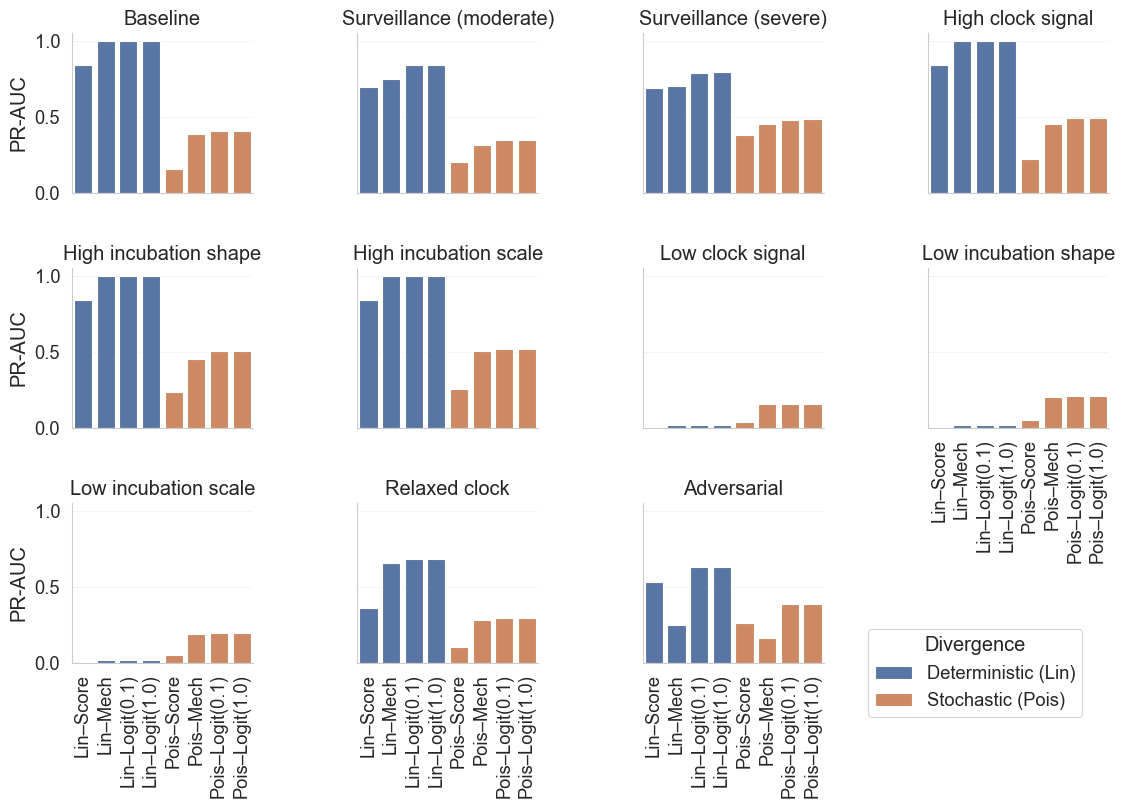

In [103]:
g = sns.catplot(
    data=edge_eval_metrics,
    kind="bar",
    x="ModelLabel",
    y="PR_AUC",
    hue="Divergence",
    order=model_order,
    col="ScenarioLabel",
    col_order=scenario_order,
    col_wrap=4,
    height=2.5,
    aspect=1.15,
    sharey=True,
    dodge=False,
)

g.set_axis_labels("", "PR-AUC")
g.set_titles("{col_name}")
g.set(ylim=(0, 1.05))

for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=90)

g.legend.set_bbox_to_anchor((0.8, 0.18))
g.legend.set_frame_on(True)

save_figure(g.figure, figs_dir / "supp_raw_pr_auc_grid.png", ["png", "pdf"])
plt.show()

#### S2) Mechanistic–logistic gap plot

I compare against Logit(1.0) (the “upper bound”). It will create two lines: deterministic and stochastic.

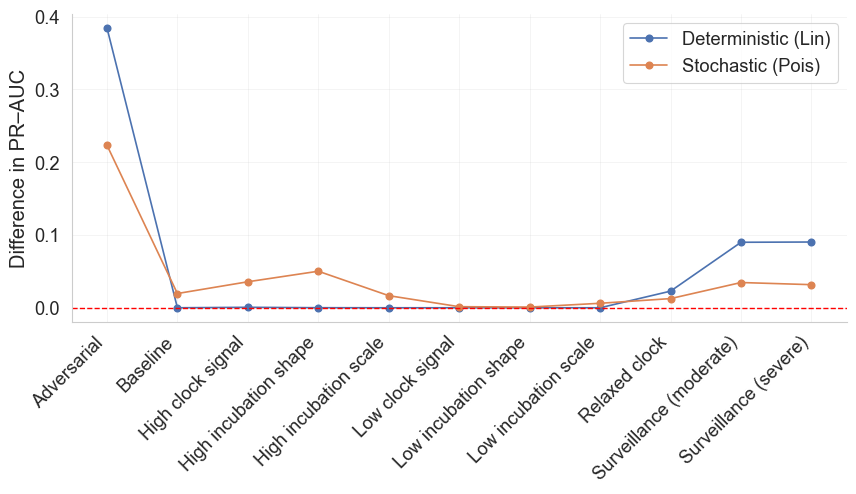

In [104]:
def get_pr_auc(scenario, model):
    sub = edge_eval_metrics[(edge_eval_metrics["Scenario"] == scenario) & (edge_eval_metrics["Model"] == model)]
    return float(float(sub["PR_AUC"].iloc[0]))

rows = []
for scen in edge_eval_metrics["Scenario"].unique():
    gap_lin = get_pr_auc(scen, "LogitProbLinearDist_1.0") - get_pr_auc(scen, "MechProbLinearDist")
    gap_pois = get_pr_auc(scen, "LogitProbPoissonDist_1.0") - get_pr_auc(scen, "MechProbPoissonDist")
    rows.append({"Scenario": scen, "Gap (deterministic)": gap_lin, "Gap (stochastic)": gap_pois})

gap_df = pd.DataFrame(rows)
gap_df["ScenarioLabel"] = gap_df["Scenario"].map(scenario_label_map)
gap_df = gap_df.sort_values("Scenario")

sup_fig1 = plt.figure(figsize=(10, 4))
plt.plot(gap_df["ScenarioLabel"].astype(str), gap_df["Gap (deterministic)"], marker="o", label="Deterministic (Lin)")
plt.plot(gap_df["ScenarioLabel"].astype(str), gap_df["Gap (stochastic)"], marker="o", label="Stochastic (Pois)")
plt.axhline(0, linewidth=1, color="red", linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Difference in PR–AUC")
plt.legend()

save_figure(sup_fig1, figs_dir / "supp_mech_vs_logit_gap", ["png", "pdf"])
plt.show()

#### S3) Deterministic–stochastic penalty plot (Poisson / Linear)

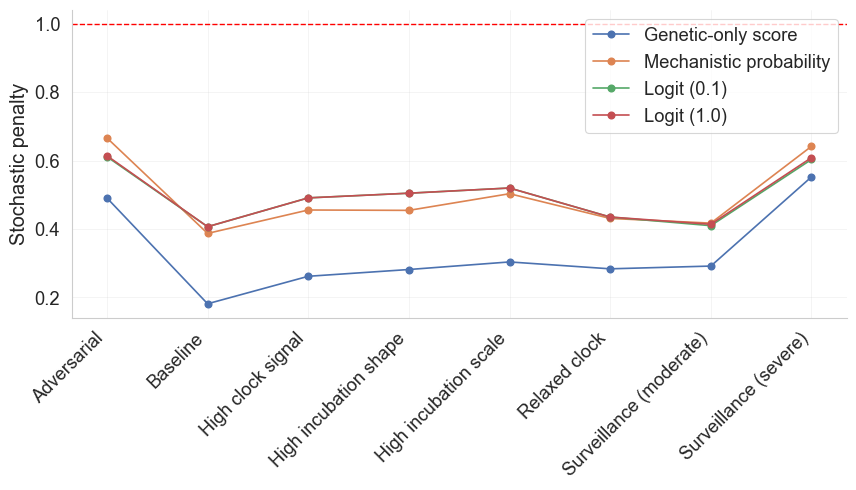

In [106]:
penalty_rows = []

scenario = ['baseline', 'surveillance_moderate',
            'surveillance_severe', 'high_clock_signal',
            'relaxed_clock', 'high_k_inc', 'high_scale_inc','adversarial']

for scen in scenario:
    # Genetic-only
    pen_score = (get_pr_auc(scen, "PoissonDistScore") /
                 get_pr_auc(scen, "LinearDistScore")) if (
            get_pr_auc(scen, "LinearDistScore") > 0) else np.nan

    # Mechanistic
    pen_mech  = (get_pr_auc(scen, "MechProbPoissonDist") /
                 get_pr_auc(scen, "MechProbLinearDist")) if (
            get_pr_auc(scen, "MechProbLinearDist") > 0) else np.nan

    # Logistic (0.1 and 1.0)
    pen_logit01 = (get_pr_auc(scen, "LogitProbPoissonDist_0.1") /
                   get_pr_auc(scen, "LogitProbLinearDist_0.1")) if (
            get_pr_auc(scen, "LogitProbLinearDist_0.1") > 0) else np.nan

    pen_logit10 = (get_pr_auc(scen, "LogitProbPoissonDist_1.0") /
                   get_pr_auc(scen, "LogitProbLinearDist_1.0")) if (
            get_pr_auc(scen, "LogitProbLinearDist_1.0") > 0) else np.nan

    penalty_rows.append({
        "Scenario": scen,
        "Genetic-only score": pen_score,
        "Mechanistic probability": pen_mech,
        "Logit (0.1)": pen_logit01,
        "Logit (1.0)": pen_logit10,
    })

pen_df = pd.DataFrame(penalty_rows)
pen_df["ScenarioLabel"] = pen_df["Scenario"].map(scenario_label_map)
pen_df = pen_df.sort_values("Scenario")

sup_fig2 = plt.figure(figsize=(10, 4))
for col in ["Genetic-only score", "Mechanistic probability", "Logit (0.1)", "Logit (1.0)"]:
    plt.plot(pen_df["ScenarioLabel"].astype(str), pen_df[col], marker="o", label=col)

plt.axhline(1, linewidth=1, color="red", linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stochastic penalty")
# plt.title("Penalty from stochastic divergence (relative to deterministic)")
plt.legend()
save_figure(sup_fig2, figs_dir / "supp_deterministic_vs_stochastic_penalty", ["png", "pdf"])
plt.show()